In [1]:
import torch, pickle
import torchvision
import torchvision.transforms as transforms

In [2]:
# Using Weights and Biases to track experiments
#!pip install wandb -qU
# Log in to your W&B account
#import wandb
#wandb.login()

# Mount google drive to save metrics, plots and S_rel
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Collaborations/Avirup/Srel/'

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn

from utils import BasicBlock
from utils import Bottleneck
from utils import conv1x1
from utils import get_model_params
from utils import load_pretrained_weights
from utils import resnet_params


class ResNet(nn.Module):

    def __init__(self, layers=None, global_params=None):
        super(ResNet, self).__init__()
        assert isinstance(layers, tuple), "blocks_args should be a tuple"
        assert len(layers) > 0, "layers must be greater than 0"
        norm_layer = global_params.norm_layer
        if global_params.norm_layer is None:
            norm_layer = nn.Identity
        
        self._norm_layer = nn.Identity

        self.inplanes = 64
        self.dilation = 1
        if global_params.replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = global_params.groups
        self.base_width = global_params.width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(global_params.block, 64, layers[0])
        self.layer2 = self._make_layer(global_params.block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(global_params.block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(global_params.block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * global_params.block.expansion, global_params.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if global_params.zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation, norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return x

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        layers, global_params = get_model_params(model_name, override_params)
        return cls(layers, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={"num_classes": num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, res = resnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (resnet_pytorch{i} for i in 18,34,50,101,152) at the moment. """
        num_models = [18, 34, 50, 101, 152]
        valid_models = ["resnet" + str(i) for i in num_models]
        if model_name not in valid_models:
            raise ValueError("model_name should be one of: " + ", ".join(valid_models))


# New Section

In [3]:
import os
import math
import random
import logging
import argparse
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import pdist,squareform
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch import linalg as LA
from random import randint
import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
import collections
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torchvision.models as models

torch.multiprocessing.set_sharing_strategy('file_system')
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform_train)
trainloader_main = torch.utils.data.DataLoader(
    trainset, batch_size=1, shuffle=True)#, num_workers=0)

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform_test)
testloader_main = torch.utils.data.DataLoader(
    trainset, batch_size=1, shuffle=True)#, num_workers=0)

#class_labels = ('0','1','2','3','4','5','6','7','8','9')#('plane', 'car', 'bird', 'cat', 'deer',
           #'dog', 'frog', 'horse', 'ship', 'truck')


data_dict = {}
class_size=4000
test_class = 800
flag=0
class_limit = 3
class_map={0:0,1:2,2:4}#{0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9}#{0:8,1:3,2:9}#{0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9}#{0:1,1:2,2:9}
class_map_1={0:0, 2:1, 4:2}

batch_size=256
num_examples = class_size*class_limit

test_length = class_limit*test_class
train_length = num_examples
print(train_length+test_length)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

14400


In [ ]:

lr = 0.0001
epsilon = 1e-8
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
def l2_norm(a):
  a = torch.square(a).sum(-1)
  a=torch.sqrt(a).mean()
  return a


def get_srel(model,x,y,x1):
    model_copy = ResNet.from_name("resnet18")
    num_ftrs = model_copy.fc.in_features
    model_copy.fc = nn.Linear(num_ftrs, class_limit)
    model_copy = model_copy.to(device)

    model_copy.load_state_dict(model.state_dict())
    #print(x.shape)

    with torch.no_grad():
        model_copy.eval()
        y1 = model_copy(x1.unsqueeze(0).to(device))

    optim_clone = optim.Adam(model_copy.parameters(), lr=lr)
    model_copy.train()
    #print(x.shape)
    y_pred = model_copy(x.unsqueeze(0).to(device))

    # print(y.shape)
    # print(y_pred.shape)

    #loss = criterion(y.to(device).reshape(-1),y_pred.reshape(-1))
    loss = criterion(y_pred,torch.argmax(y,dim=-1).to(device).unsqueeze(0))

    loss.backward()
    optim_clone.step()

    with torch.no_grad():
        model_copy.eval()
        denominator = torch.nn.functional.kl_div(torch.nn.functional.softmax(model_copy(x.unsqueeze(0).to(device))),torch.nn.functional.softmax(y_pred))+epsilon
        numerator = torch.nn.functional.kl_div(torch.nn.functional.softmax(model_copy(x1.unsqueeze(0).to(device))),torch.nn.functional.softmax(y1))

    s_rel = (numerator/denominator).mean().item()

    return s_rel

def get_srel_denom(model,x,y):
    model_copy = ResNet.from_name("resnet18")
    num_ftrs = model_copy.fc.in_features
    model_copy.fc = nn.Linear(num_ftrs, class_limit)
    model_copy = model_copy.to(device)

    model_copy.load_state_dict(model.state_dict())
    
    optim_clone = optim.Adam(model_copy.parameters(), lr=lr)
    model_copy.train()
    #print(x.shape)
    y_pred = model_copy(x.unsqueeze(0).to(device))

    # print(y.shape)
    # print(y_pred.shape)

    #loss = criterion(y.to(device).reshape(-1),y_pred.reshape(-1))
    loss = criterion(y_pred,torch.argmax(y,dim=-1).to(device).unsqueeze(0))

    loss.backward()
    optim_clone.step()
    with torch.no_grad():
        model_copy.eval()
        denominator = torch.nn.functional.kl_div(torch.nn.functional.softmax(model_copy(x.unsqueeze(0).to(device))),torch.nn.functional.softmax(y_pred))+epsilon
    #KL(g(x,w+(x)),g(x,w(x)))
    return model_copy, denominator # model_copy w+(x)

    
# temploader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = 2, shuffle = False,drop_last=True)
# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = 2, shuffle = True,drop_last=True)
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = 2, shuffle = False,drop_last=True)

# input_x=[]

# for _, (x,y) in enumerate(temploader):
#     input_x.append(x.reshape(batch_size,-1).numpy())

# def gencoordinates(m, n):
#     seen = set()

#     x, y = randint(m, n), randint(m, n)

#     while True:
#         seen.add((x, y))
#         yield (x, y)
#         x, y = randint(m, n), randint(m, n)
#         while (x, y) in seen or (x == y):
#             x, y = randint(m, n), randint(m, n)

train_idx = [i for i in range(train_length)]
# g=gencoordinates(1,len(train_idx)-1)
repeat_k = 20

pairs=[]
dictionary={}
max_x1 = randint(1,len(train_idx)-1)


        
plot_order=[]
classes = [c for c in range(class_limit)]
class_pair = {}
# import ipdb
# ipdb.set_trace()
for c in classes:
    class_pair[c] = [p for p in range(class_limit) if p!=c]

'''
for i in range(class_limit):
    plot_order.append((i,i))
    pairs.append([])
    for k in class_pair[i]:
        plot_order.append((k,i))
        pairs.append([])
'''
for _ in range(9):
    pairs.append([])
plot_order= [(0, 0), (2, 0), (4, 0), (2, 2), (0, 2), (4, 2), (4, 4), (0, 4), (2, 4)]      
        
repeat_dict = {}
for i in range(class_limit):
    repeat_dict[i] =random.sample(range(4000*i,(4000*(i+1))-1,1),repeat_k)
    #for k in repeat_k:
        
print(plot_order)
#od = collections.OrderedDict(sorted(dictionary.items()))
od = dictionary

#train_losses=[]
#test_losses=[]
#train_accs=[]
#test_accs=[]
pair_iters=[]
metrics={'train_accs':[],
         'train_losses':[],
         'test_accs':[],
         'test_losses':[]}

for run in range(3): 
    wandb.init(
      # Set the project where this run will be logged
      project="Local Elasticity", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Experiment_KL_div_2_{run+1}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "epsilon" : 1e-8,
      "architecture": "Resnet_18",
      "dataset": "SVHN",
      "epochs": 7,
      })
    
    data_dict={}
    
    #class_random = [0,3,5]#random.sample(range(0,10,1),class_limit)
    #for cl in range(class_limit):
    #    class_map[cl] = class_random[cl]
    #print(class_map)
    for i in range(class_limit):
      data_dict[i] = []
    
    print(data_dict)
    for label in range(class_limit):
      for i,(inp,target) in enumerate(trainloader_main):
        if (class_map[label] == target.item()) and (len(data_dict[label])<=class_size):
          data_dict[label].append(inp)
        if len(data_dict[label])==class_size:
          break

    xt=[]
    yt=[]
    print(data_dict.keys())
    for k in data_dict.keys():
      xt.append(torch.cat(data_dict[k]))
      yt.append(torch.LongTensor([k for _ in range(class_size)]))

    xt=torch.cat(xt,0)
    yt=torch.cat(yt,0)

    train_dataset = torch.utils.data.TensorDataset(xt,torch.nn.functional.one_hot(yt).float())

    data_dict_test = {}
    flag=0
    for i in range(class_limit):
      data_dict_test[i] = []
    
    #print(data_dict)
    for label in range(class_limit):
      for i,(inp,target) in enumerate(testloader_main):
        if (class_map[label] == target.item()) and (len(data_dict_test[label])<=test_class):
          data_dict_test[label].append(inp)
        if len(data_dict_test[label])==test_class:
          break

    xt=[]
    yt=[]
    #print(data_dict.keys())
    for k in data_dict_test.keys():
      xt.append(torch.cat(data_dict_test[k]))
      yt.append(torch.LongTensor([k for _ in range(test_class)]))

    xt=torch.cat(xt,0)
    yt=torch.cat(yt,0)

    test_dataset = torch.utils.data.TensorDataset(xt,torch.nn.functional.one_hot(yt).float())
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = 1, shuffle = True,drop_last=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = 1, shuffle = False,drop_last=True)
    
    #class_name = '_'.join([class_labels[lab] for lab in class_map.values()])
    #print(class_name)
    pairs=[]
    for i in range(class_limit):
        #plot_order.append((i,i))
        pairs.append([])
        for k in class_pair[i]:
            #plot_order.append((k,i))
            pairs.append([])    
    net = ResNet.from_name("resnet18")
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, class_limit)
    net = net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=1e-4)

    max_srel=[]
    min_srel=[]
    train_loss_list=[]
    test_loss_list=[]
    train_acc_list=[]
    test_acc_list=[]
    weight_diff=[]
    train_loss_iter=[]
    test_loss_iter =[]




    def train(epoch):
        print('\nEpoch: %d' % epoch)
        #logging.info('Epoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            #print(inputs.shape)
            optimizer.zero_grad()
            outputs = net(inputs)
            #loss = criterion(outputs.reshape(-1), targets.reshape(-1))
            loss = criterion(outputs,torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += predicted.eq(torch.argmax(targets, dim=1)).sum().item()

            train_loss += loss.item()
            total+=1
            #max_srel.append(get_srel(net,train_dataset[max_x][0],train_dataset[max_x][1],train_dataset[max_x1][0]))
            #min_srel.append(get_srel(net,train_dataset[min_x][0],train_dataset[min_x][1],train_dataset[min_x1][0]))
            
            if (batch_idx % 9)==0:
                for i,order in enumerate(plot_order):
                    num, den = order # cat (x'),plane (x)
                    num, den = class_map_1[num], class_map_1[den]   # Additional line
                    srel =0.
                    for den_el in repeat_dict[den]: # over all plane examples (x)
                        net.eval()
                        with torch.no_grad():
                            y1 = net(train_dataset[repeat_dict[num]][0].to(device)) #g(x',w)
                        net.train()
                        model_clone, denominator = get_srel_denom(net,train_dataset[den_el][0],train_dataset[den_el][1])
                        model_clone.eval()
                        ypred = model_clone(train_dataset[repeat_dict[num]][0].to(device)) #g(x',w+)
                        numerators = torch.nn.functional.kl_div(torch.nn.functional.softmax(ypred,dim=-1),torch.nn.functional.softmax(y1,dim=-1),reduction='none').mean(-1) #KL(g(x',w+(x)),g(x',w))
                        #print(denominator)
                        srels = numerators/denominator
                        srel += srels.sum(-1).item()
                    pairs[i].append(srel/(repeat_k*repeat_k))
                
                #train_loss_iter.append(train_loss/total)
                #train_acc_list.append(correct/(total*batch_size))
                #tloss,tacc = get_test_things()
                #test_loss_iter.append(tloss)
                #test_acc_list.append(tacc)
              


                #for i,t in enumerate(od.values()):
                  #cl = int(torch.argmax(train_dataset[t[0]][1],dim=-1))
                  #x_s = torch.cat(random.sample(data_dict[cl],9).append(train_dataset[t[0]][0]))
                  #x_s = data_dict[cl][:9]
                  #print(x_s[0].shape)
                  #x_s.append(train_dataset[t[0]][0].unsqueeze(0))
                  #print(x_s[-1].shape)
                  #x_s = torch.cat(x_s)
                  #y_s = torch.tensor([cl for _ in range(10)])
                  #pairs[i].append(get_srel(net,train_dataset[t[0]][0],train_dataset[t[0]][1],train_dataset[t[1]][0]))
            #weight_diff.append(model_diff(net,true_model))
            #train_loss_iter.append(loss.item())
        
        print("train_loss is %.3f after epochs %d"%(train_loss/total,epoch))
        print("train_acc is %.3f after epochs %d"%(correct/(total*batch_size),epoch))
        train_loss_list.append(train_loss/total)
        #train_acc_list.append(correct/(total*batch_size))
        #train_acc_list.extend([train_acc_list[-1] for _ in range(num_batches-1)])
        return (train_loss/total), (correct/(total*batch_size))

    num_batches = int(train_length/batch_size)
    
    def get_test_things():
        net.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                #loss = criterion(outputs, targets)
                loss = criterion(outputs,torch.argmax(targets, dim=1))

                test_loss += loss.item()
                total+=1
                _, predicted = outputs.max(1)
                correct += predicted.eq(torch.argmax(targets, dim=1)).sum().item()
        return test_loss/total,correct/(total*batch_size)


    def test(epoch):
        net.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                #loss = criterion(outputs, targets)
                loss = criterion(outputs,torch.argmax(targets, dim=1))

                test_loss += loss.item()
                total+=1
                _, predicted = outputs.max(1)
                correct += predicted.eq(torch.argmax(targets, dim=1)).sum().item()

        print("test_loss is %.3f after epochs %d"%(test_loss/total,epoch))
        print("test_acc is %.3f after epochs %d"%(correct/(total*batch_size),epoch))
#         test_loss_list.append(test_loss/total)
#         test_loss_iter.extend([test_loss_list[-1] for _ in range(num_batches-1)])
#         test_acc_list.append(correct/(total*batch_size))
#         test_acc_list.extend([test_acc_list[-1] for _ in range(num_batches-1)])
        return (test_loss/total), (correct/(total*batch_size))

    train_losses=[]
    train_accs=[]
    test_losses=[]
    test_accs=[]
    for epoch in range(0,7):
        print("EPOCH",epoch)
        train_loss, train_acc= train(epoch)
        test_loss, test_acc= test(epoch)
        metric = {"train_loss": train_loss, 
                   "train_acc": train_acc,
                   "test_loss": test_loss, 
                   "test_acc": test_acc}
        wandb.log(metric)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    pair_iters.append(pairs)
    metrics['train_accs'].append(train_accs)
    metrics['train_losses'].append(train_losses)
    metrics['test_accs'].append(test_accs)
    metrics['test_losses'].append(test_losses)
    # Close wandb run
    wandb.finish()

# Saving metrics and S_rel
with open(path+'metrics_dictionary_svhn_kl.pkl', 'wb') as f:
    pickle.dump(metrics, f)

with open(path+"pair_iters_svhn_kl.pkl", "wb") as f:
   pickle.dump(pair_iters, f)


wandb: Currently logged in as: anirbit-research. Use `wandb login --relogin` to force relogin


[(0, 0), (2, 0), (4, 0), (2, 2), (0, 2), (4, 2), (4, 4), (0, 4), (2, 4)]


{0: [], 1: [], 2: []}
dict_keys([0, 1, 2])
EPOCH 0

Epoch: 0


<ipython-input-5-1cf04a618c70>:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  denominator = torch.nn.functional.kl_div(torch.nn.functional.softmax(model_copy(x.unsqueeze(0).to(device))),torch.nn.functional.softmax(y_pred))+epsilon
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train_loss is 1.067 after epochs 0
train_acc is 0.421 after epochs 0
test_loss is 0.973 after epochs 0
test_acc is 0.450 after epochs 0
EPOCH 1

Epoch: 1
train_loss is 0.816 after epochs 1
train_acc is 0.620 after epochs 1
test_loss is 0.701 after epochs 1
test_acc is 0.712 after epochs 1
EPOCH 2

Epoch: 2
train_loss is 0.627 after epochs 2
train_acc is 0.733 after epochs 2
test_loss is 0.631 after epochs 2
test_acc is 0.720 after epochs 2
EPOCH 3

Epoch: 3
train_loss is 0.495 after epochs 3
train_acc is 0.797 after epochs 3
test_loss is 0.488 after epochs 3
test_acc is 0.816 after epochs 3
EPOCH 4

Epoch: 4
train_loss is 0.419 after epochs 4
train_acc is 0.835 after epochs 4
test_loss is 0.439 after epochs 4
test_acc is 0.831 after epochs 4
EPOCH 5

Epoch: 5
train_loss is 0.346 after epochs 5
train_acc is 0.867 after epochs 5
test_loss is 0.408 after epochs 5
test_acc is 0.848 after epochs 5
EPOCH 6

Epoch: 6
train_loss is 0.281 after epochs 6
train_acc is 0.896 after epochs 6
test_lo

test_acc,▁▅▆▇▇██
test_loss,█▅▄▂▂▁▁
train_acc,▁▄▆▇▇██
train_loss,█▆▄▃▂▂▁
test_acc,0.86155
test_loss,0.38065
train_acc,0.89572
train_loss,0.28072


{0: [], 1: [], 2: []}
dict_keys([0, 1, 2])
EPOCH 0

Epoch: 0
train_loss is 1.074 after epochs 0
train_acc is 0.418 after epochs 0
test_loss is 0.938 after epochs 0
test_acc is 0.612 after epochs 0
EPOCH 1

Epoch: 1
train_loss is 0.787 after epochs 1
train_acc is 0.656 after epochs 1
test_loss is 0.653 after epochs 1
test_acc is 0.732 after epochs 1
EPOCH 2

Epoch: 2
train_loss is 0.573 after epochs 2
train_acc is 0.767 after epochs 2
test_loss is 0.566 after epochs 2
test_acc is 0.782 after epochs 2
EPOCH 3

Epoch: 3
train_loss is 0.465 after epochs 3
train_acc is 0.820 after epochs 3
test_loss is 0.519 after epochs 3
test_acc is 0.797 after epochs 3
EPOCH 4

Epoch: 4
train_loss is 0.373 after epochs 4
train_acc is 0.861 after epochs 4
test_loss is 0.426 after epochs 4
test_acc is 0.842 after epochs 4
EPOCH 5

Epoch: 5
train_loss is 0.323 after epochs 5
train_acc is 0.876 after epochs 5
test_loss is 0.398 after epochs 5
test_acc is 0.849 after epochs 5
EPOCH 6

Epoch: 6
train_loss is 0

test_acc,▁▄▆▆▇██
test_loss,█▅▃▃▂▁▁
train_acc,▁▄▆▇▇██
train_loss,█▅▄▃▂▁▁
test_acc,0.86675
test_loss,0.364
train_acc,0.8981
train_loss,0.27458


{0: [], 1: [], 2: []}
dict_keys([0, 1, 2])
EPOCH 0

Epoch: 0
train_loss is 1.052 after epochs 0
train_acc is 0.429 after epochs 0
test_loss is 0.931 after epochs 0
test_acc is 0.529 after epochs 0
EPOCH 1

Epoch: 1
train_loss is 0.807 after epochs 1
train_acc is 0.631 after epochs 1
test_loss is 0.744 after epochs 1
test_acc is 0.664 after epochs 1
EPOCH 2

Epoch: 2
train_loss is 0.627 after epochs 2
train_acc is 0.737 after epochs 2
test_loss is 0.585 after epochs 2
test_acc is 0.762 after epochs 2
EPOCH 3

Epoch: 3
train_loss is 0.484 after epochs 3
train_acc is 0.814 after epochs 3
test_loss is 0.535 after epochs 3
test_acc is 0.788 after epochs 3
EPOCH 4

Epoch: 4
train_loss is 0.412 after epochs 4
train_acc is 0.841 after epochs 4
test_loss is 0.450 after epochs 4
test_acc is 0.819 after epochs 4
EPOCH 5

Epoch: 5
train_loss is 0.324 after epochs 5
train_acc is 0.876 after epochs 5
test_loss is 0.372 after epochs 5
test_acc is 0.862 after epochs 5
EPOCH 6

Epoch: 6
train_loss is 0

test_acc,▁▄▆▆▇██
test_loss,█▆▄▃▂▁▁
train_acc,▁▄▆▇▇██
train_loss,█▆▄▃▂▂▁
test_acc,0.85156
test_loss,0.38343
train_acc,0.90158
train_loss,0.26454


In [ ]:
def test_classwise():
    net.eval()
    correct = 0
    total = 0
    accuracies=np.zeros(10)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            total+=1
            _, predicted = outputs.max(1)
            vals=predicted.eq(torch.argmax(targets, dim=1))
            correct += vals.sum().item()
            
            temp=torch.argmax(targets, dim=1).cpu().numpy()
            
            temp_correct=vals.cpu().numpy()
            for i in range(256):
                accuracies[temp[i]]+=vals[i]
    print("test_acc is %.3f after epochs %d"%(correct/(total*batch_size),epoch))
    print(accuracies/800.0)
test_classwise()

test_acc is 0.852 after epochs 6
[0.84625 0.8525  0.75375 0.      0.      0.      0.      0.      0.
 0.     ]


In [4]:
# Fetching metrics from Drive
with open(path+'pair_iters_svhn_kl.pkl','rb') as f:
    pair_iters=pickle.load(f)

with open(path+'metrics_dictionary_svhn_kl.pkl', 'rb') as f:
    metrics=pickle.load(f)

In [5]:
import numpy as np
pair_means=np.mean(np.array(pair_iters[0:3]),0)
pair_sds=np.std(np.array(pair_iters[0:3]),0)

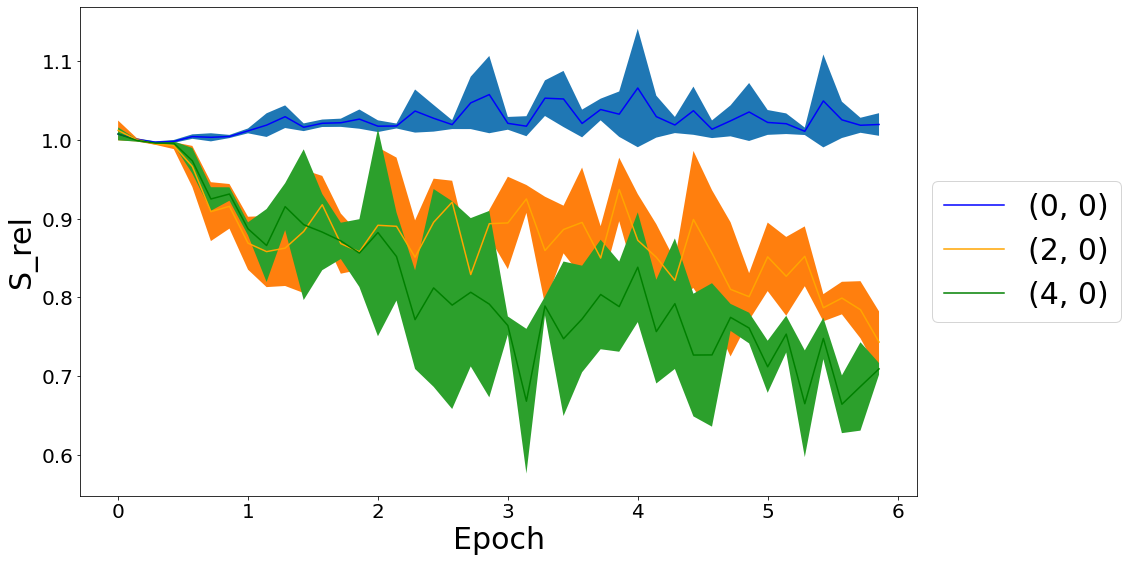

In [6]:
import matplotlib.pyplot as plt
#test_list=range(7)
#epochs =  [ele for ele in test_list for i in range(7)]
x=np.arange(42)/7.0
#x=np.repeat(x,6)
plt.figure(figsize=(15,9))
plt.plot(x,pair_means[0],label="(0, 0)",color='blue')
plt.fill_between(x,pair_means[0]-pair_sds[0],pair_means[0]+pair_sds[0])
plt.plot(x,pair_means[1],label='(2, 0)',color='orange')
plt.fill_between(x,pair_means[1]-pair_sds[1],pair_means[1]+pair_sds[1])
plt.plot(x,pair_means[2],label='(4, 0)',color='green')
plt.fill_between(x,pair_means[2]-pair_sds[2],pair_means[2]+pair_sds[2])

'''
plt.plot(range(len(pair_means[0])),pair_means[3],label='11')
plt.plot(range(len(pair_means[0])),pair_means[4],label='01')
plt.plot(range(len(pair_means[0])),pair_means[5],label='21')
plt.plot(range(len(pair_means[0])),pair_means[6],label='22')
plt.plot(range(len(pair_means[0])),pair_means[7],label='02')
plt.plot(range(len(pair_means[0])),pair_means[8],label='12')
'''
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("S_rel", fontsize=30)
plt.savefig(path+'Plots/SVHN_KL_plot1.jpg',bbox_inches='tight')

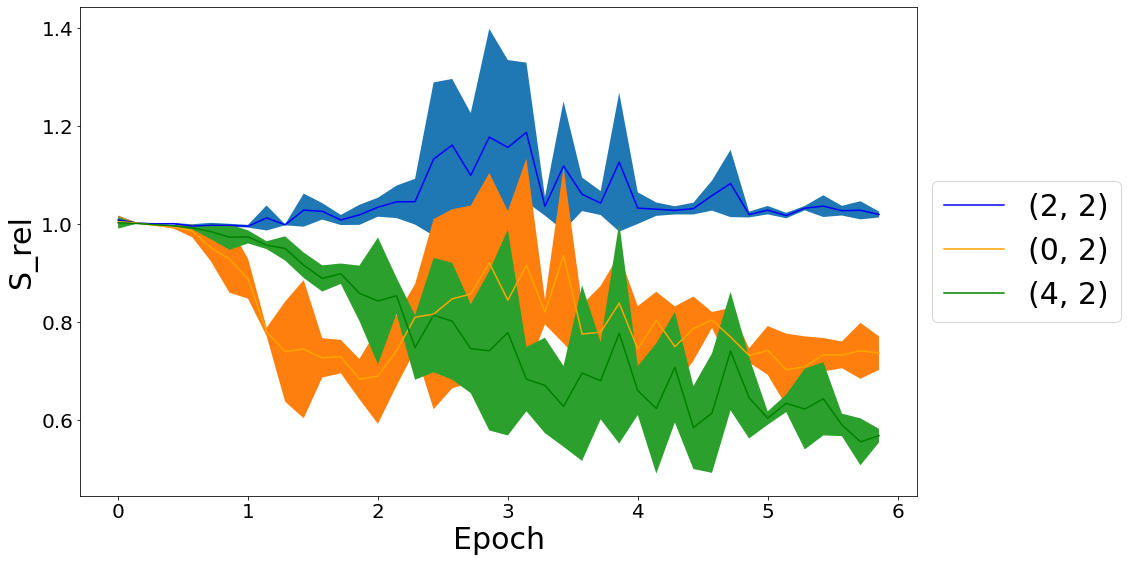

In [7]:
import matplotlib.pyplot as plt
#test_list=range(7)
#epochs =  [ele for ele in test_list for i in range(7)]
x=np.arange(42)/7.0
#x=np.repeat(x,6)
plt.figure(figsize=(15,9))
plt.plot(x,pair_means[3],label="(2, 2)",color='blue')
plt.fill_between(x,pair_means[3]-pair_sds[3],pair_means[3]+pair_sds[3])
plt.plot(x,pair_means[4],label='(0, 2)',color='orange')
plt.fill_between(x,pair_means[4]-pair_sds[4],pair_means[4]+pair_sds[4])
plt.plot(x,pair_means[5],label='(4, 2)',color='green')
plt.fill_between(x,pair_means[5]-pair_sds[5],pair_means[5]+pair_sds[5])

'''
plt.plot(range(len(pair_means[0])),pair_means[3],label='11')
plt.plot(range(len(pair_means[0])),pair_means[4],label='01')
plt.plot(range(len(pair_means[0])),pair_means[5],label='21')
plt.plot(range(len(pair_means[0])),pair_means[6],label='22')
plt.plot(range(len(pair_means[0])),pair_means[7],label='02')
plt.plot(range(len(pair_means[0])),pair_means[8],label='12')
'''
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("S_rel", fontsize=30)
plt.savefig(path+'Plots/SVHN_KL_plot2.jpg',bbox_inches='tight')

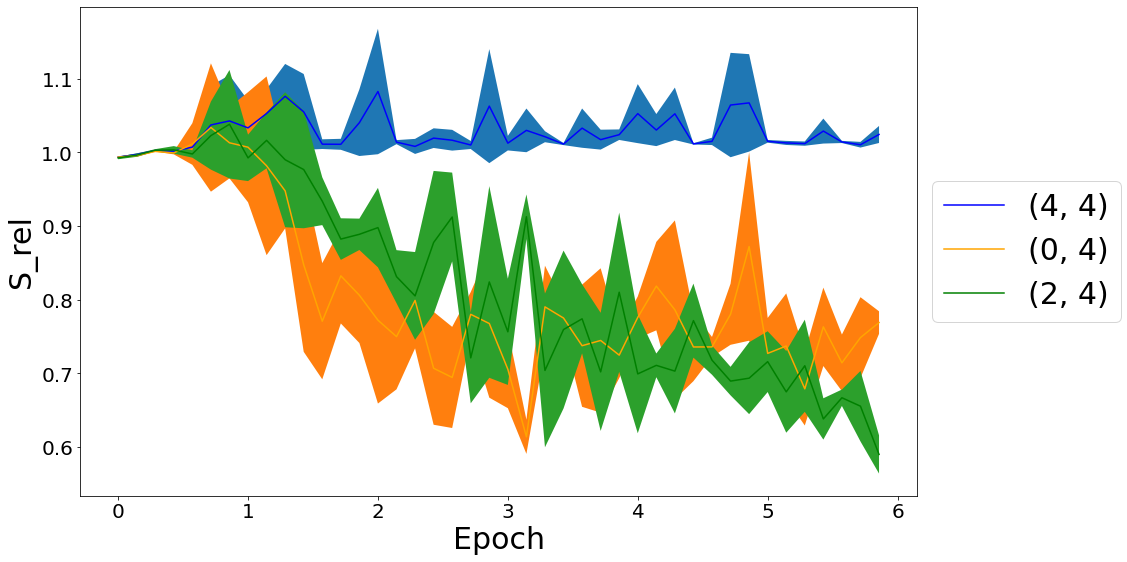

In [8]:
import matplotlib.pyplot as plt
#test_list=range(7)
#epochs =  [ele for ele in test_list for i in range(7)]
x=np.arange(42)/7.0
#x=np.repeat(x,6)
plt.figure(figsize=(15,9))
plt.plot(x,pair_means[6],label="(4, 4)",color='blue')
plt.fill_between(x,pair_means[6]-pair_sds[6],pair_means[6]+pair_sds[6])
plt.plot(x,pair_means[7],label='(0, 4)',color='orange')
plt.fill_between(x,pair_means[7]-pair_sds[7],pair_means[7]+pair_sds[7])
plt.plot(x,pair_means[8],label='(2, 4)',color='green')
plt.fill_between(x,pair_means[8]-pair_sds[8],pair_means[8]+pair_sds[8])

'''
plt.plot(range(len(pair_means[0])),pair_means[3],label='11')
plt.plot(range(len(pair_means[0])),pair_means[4],label='01')
plt.plot(range(len(pair_means[0])),pair_means[5],label='21')
plt.plot(range(len(pair_means[0])),pair_means[6],label='22')
plt.plot(range(len(pair_means[0])),pair_means[7],label='02')
plt.plot(range(len(pair_means[0])),pair_means[8],label='12')
'''
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("S_rel", fontsize=30)
plt.savefig(path+'Plots/SVHN_KL_plot3.jpg',bbox_inches='tight')

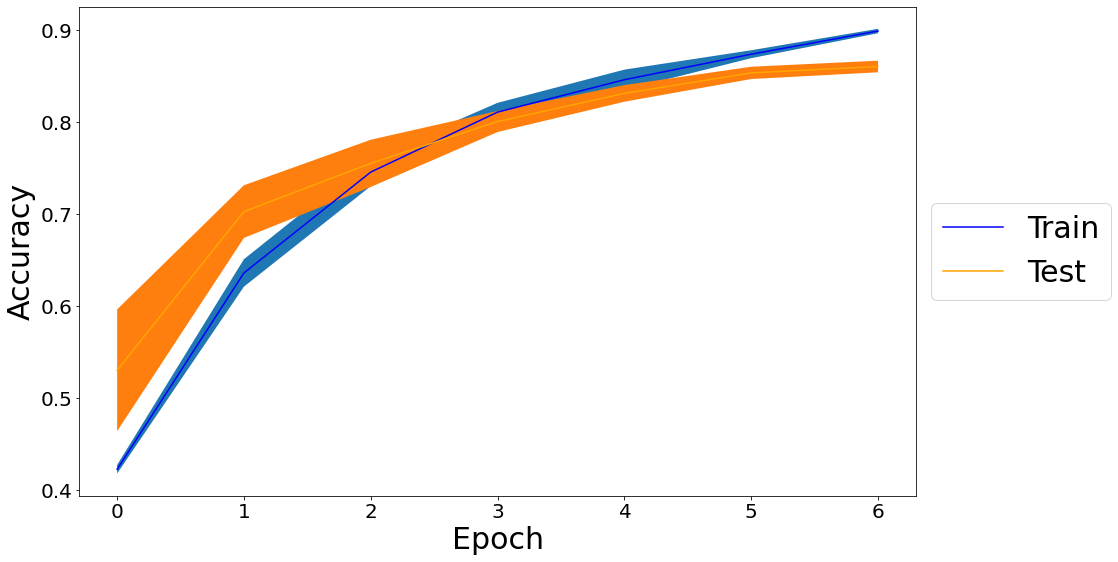

In [9]:
x=np.arange(7)
plt.figure(figsize=(15,9))
plt.plot(x,np.mean(metrics['train_accs'],0),label="Train",color='blue')
plt.fill_between(x,np.mean(metrics['train_accs'],0)-np.std(metrics['train_accs'],0),np.mean(metrics['train_accs'],0)+np.std(metrics['train_accs'],0))
plt.plot(x,np.mean(metrics['test_accs'],0),label="Test",color='orange')
plt.fill_between(x,np.mean(metrics['test_accs'],0)-np.std(metrics['test_accs'],0),np.mean(metrics['test_accs'],0)+np.std(metrics['test_accs'],0))
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.savefig(path+'Plots/SVHN_KL_acc.jpg',bbox_inches='tight')

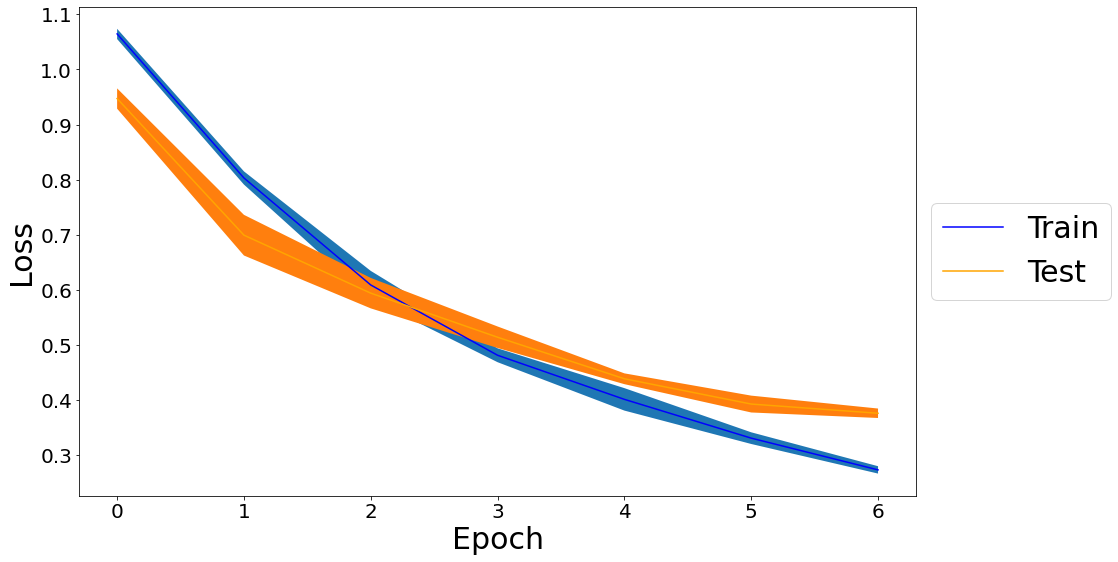

In [10]:
x=np.arange(7)
plt.figure(figsize=(15,9))
plt.plot(x,np.mean(metrics['train_losses'],0),label="Train",color='blue')
plt.fill_between(x,np.mean(metrics['train_losses'],0)-np.std(metrics['train_losses'],0),np.mean(metrics['train_losses'],0)+np.std(metrics['train_losses'],0))
plt.plot(x,np.mean(metrics['test_losses'],0),label="Test",color='orange')
plt.fill_between(x,np.mean(metrics['test_losses'],0)-np.std(metrics['test_losses'],0),np.mean(metrics['test_losses'],0)+np.std(metrics['test_losses'],0))
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Epoch", fontsize=30)
plt.ylabel("Loss", fontsize=30)
plt.savefig(path+'Plots/SVHN_KL_losses.jpg',bbox_inches='tight')